# Data Preprocessing Stage 2
This notebook will handle aggregating external datasets.

In [21]:
# Initialise a spark session
import pandas as pd
from collections import Counter
import os
from pyspark.sql import SparkSession
from pyspark.sql import functions as F


spark = (
    SparkSession.builder.appName("Data Processing 2")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "8g")  # Increase driver memory
    .config("spark.executor.memory", "8g")  # Increase executor memory
    .config("spark.executor.instances", "4")  # Increase the number of executor instances
    .config("spark.driver.maxResultSize", "2g")
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()
)

In [22]:
# Load Datasets
transaction_data = spark.read.parquet('../data/curated/complete_data')
postcode_to_sa4 = spark.read.csv('../data/external/POSTCODE_2011_TO_SA4.csv', header=True)
unemployment_rate = spark.read.csv('../data/external/Unemployment_Rate_SA4.csv', header=True)

In [23]:
unemployment_rate.show(5)

+--------------------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+
|                 SA4|Jul-24|Jun-24|May-24|Apr-24|Mar-24|Feb-24|Jan-24|Dec-23|Nov-23|Oct-23|Sep-23|Aug-23|Jul-23|Jun-23|May-23|Apr-23|Mar-23|Feb-23|Jan-23|Dec-22|Nov-22|Oct-22|Sep-22|Aug-22|Jul-22|Jun-22|May-22|Apr-22|Mar-22|Feb-22|Jan-22|Dec-21|Nov-21|Oct-21|Sep-21|Aug-21|Jul-21|Jun-21|May-21|Apr-21|Mar-21|Feb-21|Jan-21|Dec-20|Nov-20|Oct-20|Sep-20|Aug-20|Jul-20|Jun-20|May-20|Apr-20|Mar-20|Feb-20|Jan-20|
+--------------------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+-

### Reformatting Unemployment Data
Split the SA4 Code and the SA4 area name.

In [24]:
unemployment_rate = unemployment_rate.withColumn(
    "SA4_code", F.regexp_extract(F.col("SA4"), r"^\d+", 0)  # Extract the numeric part (SA4 code)
).withColumn(
    "SA4_name", F.regexp_replace(F.col("SA4"), r"^\d+\s*", "")  # Extract the remaining string (SA4 name)
)

unemployment_rate = unemployment_rate.drop('SA4')

# Show the result with the new columns
unemployment_rate.select("SA4_code", "SA4_name").show(5)


+--------+--------------------+
|SA4_code|            SA4_name|
+--------+--------------------+
|     102|       Central Coast|
|     115|Sydney - Baulkham...|
|     116|  Sydney - Blacktown|
|     117|Sydney - City and...|
|     118|Sydney - Eastern ...|
+--------+--------------------+
only showing top 5 rows



In [25]:
# List of month-year columns in unemployment_rate
month_year_columns = unemployment_rate.columns[2:]  # Exclude SA4 code and SA4 name columns

# Create a stack expression for unpivoting the unemployment_rate DataFrame
stack_expr = F.expr(f"stack({len(month_year_columns)}, " + 
                    ", ".join([f"'{col}', `{col}`" for col in month_year_columns]) + 
                    ") as (month_year, unemployment_rate)")

# Unpivot the unemployment_rate DataFrame
unemployment_rate = unemployment_rate.select(
    "SA4_code",
    "SA4_name",
    stack_expr
)

# Show the reshaped DataFrame
unemployment_rate.show(5)


+--------+-------------+----------+-----------------+
|SA4_code|     SA4_name|month_year|unemployment_rate|
+--------+-------------+----------+-----------------+
|     102|Central Coast|    May-24|            119.1|
|     102|Central Coast|    Apr-24|            120.5|
|     102|Central Coast|    Mar-24|            118.9|
|     102|Central Coast|    Feb-24|            119.5|
|     102|Central Coast|    Jan-24|            121.6|
+--------+-------------+----------+-----------------+
only showing top 5 rows



### Reformatting Datetime Format
To match the external dataset format, the order datetime will be converted to MMM-YY format.

In [26]:
# Convert the order_datetime column to the MMM-YY format
transaction_data = transaction_data.withColumn(
    "order_month_year", F.date_format(F.col("order_datetime"), "MMM-yy")
)

# Show the result
transaction_data.select("order_datetime", "order_month_year").show(5)

+--------------+----------------+
|order_datetime|order_month_year|
+--------------+----------------+
|    2021-09-20|          Sep-21|
|    2021-09-20|          Sep-21|
|    2021-09-20|          Sep-21|
|    2021-09-20|          Sep-21|
|    2021-09-20|          Sep-21|
+--------------+----------------+
only showing top 5 rows



## Aggregating Dataset

In [27]:
postcode_to_sa4.printSchema()

root
 |-- POSTCODE: string (nullable = true)
 |-- SA4_CODE_2011: string (nullable = true)
 |-- SA4_NAME_2011: string (nullable = true)



In [28]:
# Join transaction data and sa4 converter by postcode
merged_external = transaction_data.join(postcode_to_sa4, transaction_data["postcode_consumer"] == postcode_to_sa4["POSTCODE"], "left")
merged_external = merged_external.drop("POSTCODE")

# Show the result
merged_external.show(5)

+-------+------------+------------------+--------------------+-----------+--------------------------+-------------+-----------------+--------------+-----------------+---------------+--------------------+--------------------+--------------------------+--------------+----------------+-------------+-------------+
|user_id|merchant_abn|      dollar_value|            order_id|consumer_id|fraud_probability_consumer|name_consumer| address_consumer|state_consumer|postcode_consumer|gender_consumer|       name_merchant|                tags|fraud_probability_merchant|order_datetime|order_month_year|SA4_CODE_2011|SA4_NAME_2011|
+-------+------------+------------------+--------------------+-----------+--------------------------+-------------+-----------------+--------------+-----------------+---------------+--------------------+--------------------+--------------------------+--------------+----------------+-------------+-------------+
|     20| 83679168109|215.64397454304893|000c4b07-b771-468...|  

In [29]:
merged_external.printSchema()

root
 |-- user_id: long (nullable = true)
 |-- merchant_abn: long (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- consumer_id: long (nullable = true)
 |-- fraud_probability_consumer: double (nullable = true)
 |-- name_consumer: string (nullable = true)
 |-- address_consumer: string (nullable = true)
 |-- state_consumer: string (nullable = true)
 |-- postcode_consumer: integer (nullable = true)
 |-- gender_consumer: string (nullable = true)
 |-- name_merchant: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- fraud_probability_merchant: double (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- order_month_year: string (nullable = true)
 |-- SA4_CODE_2011: string (nullable = true)
 |-- SA4_NAME_2011: string (nullable = true)



In [30]:
# Join merged data with sa4 unemployment rate by sa4 code
merged_external = merged_external.join(unemployment_rate, (merged_external["SA4_CODE_2011"] == unemployment_rate["SA4_code"]) 
                                       & (merged_external["order_month_year"] == unemployment_rate["month_year"]), "left")

merged_external = merged_external.drop("SA4_code")
merged_external = merged_external.drop("SA4_name")
merged_external = merged_external.drop("month_year")

In [31]:
merged_external.show(5)

+-------+------------+------------------+--------------------+-----------+--------------------------+-------------+-----------------+--------------+-----------------+---------------+--------------------+--------------------+--------------------------+--------------+----------------+-------------+-------------+-----------------+
|user_id|merchant_abn|      dollar_value|            order_id|consumer_id|fraud_probability_consumer|name_consumer| address_consumer|state_consumer|postcode_consumer|gender_consumer|       name_merchant|                tags|fraud_probability_merchant|order_datetime|order_month_year|SA4_CODE_2011|SA4_NAME_2011|unemployment_rate|
+-------+------------+------------------+--------------------+-----------+--------------------------+-------------+-----------------+--------------+-----------------+---------------+--------------------+--------------------+--------------------------+--------------+----------------+-------------+-------------+-----------------+
|     20| 

## Checking for Null Values

In [32]:
from pyspark.sql.functions import col 

null_sa4_code = merged_external.filter(col("SA4_CODE_2011").isNull()).count()
print(f"Number of null values in the 'SA4_CODE_2011' column: {null_sa4_code}")

Number of null values in the 'SA4_CODE_2011' column: 2281553


Some of the postcodes are not available in the existing SA4 code database, so for these cases, the unemployment rate will be imputed by median imputation of the median unemployment rate during the corresponding order month year.

In [34]:
#  Identify rows with missing SA4 codes or unemployment rates
missing_unemployment_df = merged_external.filter(F.col("unemployment_rate").isNull())

# Calculate the median unemployment rate for each month_year
median_unemployment_by_month = unemployment_rate.groupBy("month_year").agg(
    F.expr("percentile_approx(unemployment_rate, 0.5)").alias("median_unemployment_rate")
)

# Join the missing unemployment rows with the median unemployment rate based on month_year
missing_imputed_df = missing_unemployment_df.join(
    median_unemployment_by_month, 
    missing_unemployment_df["order_month_year"] == median_unemployment_by_month["month_year"], 
    how="left"
).withColumn(
    "unemployment_rate", F.coalesce(F.col("unemployment_rate"), F.col("median_unemployment_rate"))
).drop("median_unemployment_rate", "month_year")

# Merge the imputed rows back into the main DataFrame
# Keep rows where unemployment_rate is not null, and union with the imputed DataFrame
imputed_data = merged_external.filter(F.col("unemployment_rate").isNotNull()).union(missing_imputed_df)

# Show the result
imputed_data.show(5)


+-------+------------+------------------+--------------------+-----------+--------------------------+--------------+--------------------+--------------+-----------------+---------------+--------------------+--------------------+--------------------------+--------------+----------------+-------------+--------------------+-----------------+
|user_id|merchant_abn|      dollar_value|            order_id|consumer_id|fraud_probability_consumer| name_consumer|    address_consumer|state_consumer|postcode_consumer|gender_consumer|       name_merchant|                tags|fraud_probability_merchant|order_datetime|order_month_year|SA4_CODE_2011|       SA4_NAME_2011|unemployment_rate|
+-------+------------+------------------+--------------------+-----------+--------------------------+--------------+--------------------+--------------+-----------------+---------------+--------------------+--------------------+--------------------------+--------------+----------------+-------------+-----------------

In [38]:
null_unemp = imputed_data.filter(col("unemployment_rate").isNull()).count()
print(f"Number of null values in the 'unemployment_rate' column: {null_unemp}")

Number of null values in the 'unemployment_rate' column: 0


In [41]:
from pyspark.sql.functions import lit

# Group null SA4_code into a category like 'Unregistered Area'
imputed_data = imputed_data.withColumn(
    "SA4_CODE_2011", F.coalesce(F.col("SA4_CODE_2011"), lit("Unregistered"))
).withColumn(
    "SA4_NAME_2011", F.coalesce(F.col("SA4_NAME_2011"), lit("Unregistered Area"))
)

## Analyzing Outliers in Dollar Value

In [57]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import mean, stddev, col, abs

# Step 1: Calculate Z-Score for the entire dataset (imputed_data)
column = "dollar_value"

# Calculate the mean and standard deviation on the entire dataset
stats = imputed_data.select(mean(col(column)).alias('mean'), stddev(col(column)).alias('stddev')).collect()
mean_value = stats[0]['mean']
stddev_value = stats[0]['stddev']

# Add Z-Score column to the entire dataset for outlier detection
imputed_data = imputed_data.withColumn(
    "z_score", (col(column) - mean_value) / stddev_value
)

# Take a sample for plotting
sample_fraction = 0.2
sampled_data = imputed_data.sample(withReplacement=False, fraction=sample_fraction, seed=42)

# Convert the sampled data to Pandas for initial plotting
df_pandas_before = sampled_data.select("dollar_value").toPandas()

# Filter out the outliers from the sample and from the whole dataset
df_without_outliers = sampled_data.filter(abs(col("z_score")) <= 3).select("dollar_value").toPandas()
filter_outliers = imputed_data.filter(abs(col("z_score")) <= 3)

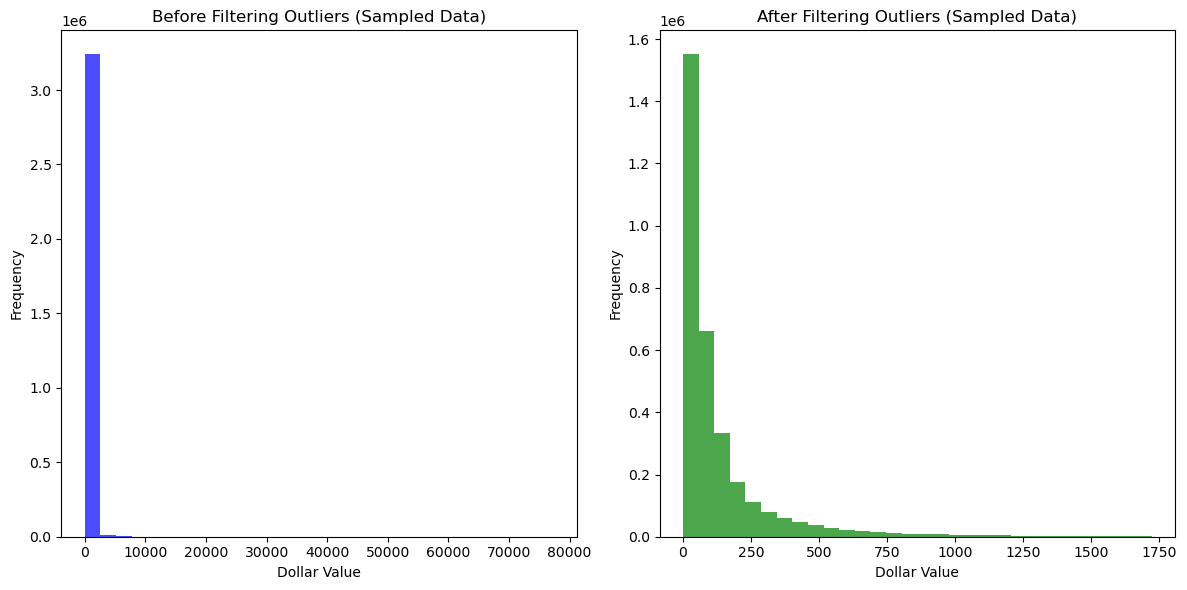

In [58]:
plt.figure(figsize=(12, 6))

# Before filtering outliers (using the sample)
plt.subplot(1, 2, 1)
plt.hist(df_pandas_before['dollar_value'], bins=30, color='blue', alpha=0.7)
plt.title('Before Filtering Outliers (Sampled Data)')
plt.xlabel('Dollar Value')
plt.ylabel('Frequency')

# After filtering outliers (using the sample)
plt.subplot(1, 2, 2)
plt.hist(df_without_outliers['dollar_value'], bins=30, color='green', alpha=0.7)
plt.title('After Filtering Outliers (Sampled Data)')
plt.xlabel('Dollar Value')
plt.ylabel('Frequency')

# Show the plots
plt.tight_layout()
plt.show()


## Export Data to Parquet

In [60]:
#filter_outliers.write.parquet("../data/curated/aggregated_data")